# Set Up

In [57]:
from typing import List
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T

import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
from PIL import Image
from tqdm import tqdm
from cProfile import label

In [3]:
device = None

# check if MPS (Apple Silicon GPU) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
# check if CUDA (NVIDIA GPU) is available
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
else:
    device = torch.device("cpu")
    print ("MPS and CUDA device not found.")

# **Image Classification by Clothing Type**

# Load Data

In [4]:
IMAGE_DIR = "../data/images/"
SEGM_DIR = "../data/segm/"

In [12]:

class DeepFashionMultiItemDataset(Dataset):
    def __init__(self, img_dir, segm_dir, transform=None):
        self.img_dir = img_dir
        self.segm_dir = segm_dir
        self.transform = transform
        
        # Map from the Human Parsing Label Table to our target classes (0-6)
        self.target_map = {
            1: 0,  # top -> class 0
            2: 1,  # outer -> class 1
            3: 2,  # skirt -> class 2
            4: 3,  # dress -> class 3
            5: 4,  # pants -> class 4
            6: 5,  # leggings -> class 5
            21: 6  # rompers -> class 6
        }
        # List of original IDs we want to find (1, 2, 3, 4, 5, 6, 21)
        self.interest_ids = set(self.target_map.keys())

        # Build list of samples by prescanning the data
        self.samples = []
        
        # Get all potential jpg files
        all_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        print(f"Pre-scanning {len(all_files)} images to find all clothing items...")
        
        # We use tqdm to show a progress bar because this might take a moment
        for img_name in tqdm(all_files):
            base_name = os.path.splitext(img_name)[0]
            segm_name = f"{base_name}_segm.png"
            segm_path = os.path.join(segm_dir, segm_name)
            
            if os.path.exists(segm_path):
                # Open the mask to see what's inside
                segm_np = np.array(Image.open(segm_path))
                unique_labels = np.unique(segm_np)
                
                # Check every label found in this image
                for label in unique_labels:
                    if label in self.interest_ids:
                        # Add sample, store: (filename, original_pixel_value_to_look_for)
                        self.samples.append((img_name, label))
                        
        print(f"Scanning complete. Created {len(self.samples)} samples from {len(all_files)} images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Retrieve the specific pair we found during init
        img_name, original_id = self.samples[idx]
        
        # Make paths
        img_path = os.path.join(self.img_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        segm_path = os.path.join(self.segm_dir, f"{base_name}_segm.png")
        
        # Load Data
        image = Image.open(img_path).convert('RGB')
        segm = np.array(Image.open(segm_path)) # Load mask as numpy array
        
        # Mask the image so we only take the relevant clothing item
        mask_binary = (segm == original_id).astype(np.uint8)
        mask_img = Image.fromarray(mask_binary)
        
        # Resize Mask to match ResNet Model Input (224x224)
        mask_img = mask_img.resize((224, 224), resample=Image.NEAREST)
        mask_tensor = torch.tensor(np.array(mask_img), dtype=torch.float32)
        
        # Get the Model Target Label (0-6)
        target_label = self.target_map[original_id]
        
        # Transform Image
        if self.transform:
            image = self.transform(image)
            
        return image, mask_tensor, torch.tensor(target_label)
    

In [13]:
# Setup Data Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize with Train-Test Split
dataset = DeepFashionMultiItemDataset(IMAGE_DIR, SEGM_DIR, transform=transform)
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_set, test_set = random_split(
    dataset,
    [train_len, test_len],
    generator=torch.Generator().manual_seed(42)  # keep split reproducible
)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print("Dataset ready.")
print(f"Total samples: {len(dataset)} | Train: {len(train_set)} | Test: {len(test_set)}")

Pre-scanning 44096 images to find all clothing items...


100%|██████████| 44096/44096 [01:30<00:00, 485.20it/s]

Scanning complete. Created 25212 samples from 44096 images.
Dataset ready.
Total samples: 25212 | Train: 20169 | Test: 5043


# Model 1


In [14]:
class FashionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(FashionResNet, self).__init__()
        # Load Pre-trained ResNet50
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Replace the last layer (fc) to match our 7 classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

model = FashionResNet().to(device)
print("Model initialized.")

Model initialized.


# Train

Hyperparameters

In [15]:
learning_rate = 1e-3
num_epochs = 10
criterion = nn.CrossEntropyLoss(ignore_index=-1) # Ignore images with no valid clothes
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training Loop

In [16]:

# Normalization layer (applied after masking)
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

print("Starting Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, masks, labels) in enumerate(train_loader):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        
        # Expand mask to match image channels (Batch, 1, H, W) -> (Batch, 3, H, W)
        masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
        # Black out background
        masked_images = images * masks
        # Normalize
        model_inputs = normalizer(masked_images)
        
        # Train
        optimizer.zero_grad()
        outputs = model(model_inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")
            
    print(f"Epoch [{epoch+1}/{num_epochs}] complete. Average Loss: {running_loss / len(train_loader):.4f}")
            
print("Training complete.")

Starting Training...
Epoch [1/10], Step [0], Loss: 1.9171
Epoch [1/10], Step [100], Loss: 0.3145
Epoch [1/10], Step [200], Loss: 0.6335
Epoch [1/10], Step [300], Loss: 0.4949
Epoch [1/10], Step [400], Loss: 0.0642
Epoch [1/10], Step [500], Loss: 0.2606
Epoch [1/10], Step [600], Loss: 0.0796
Epoch [1/10] complete. Average Loss: 0.3475
Epoch [2/10], Step [0], Loss: 0.3800
Epoch [2/10], Step [100], Loss: 0.1914
Epoch [2/10], Step [200], Loss: 0.2416
Epoch [2/10], Step [300], Loss: 0.0788
Epoch [2/10], Step [400], Loss: 0.2243
Epoch [2/10], Step [500], Loss: 0.1626
Epoch [2/10], Step [600], Loss: 0.1526
Epoch [2/10] complete. Average Loss: 0.2187
Epoch [3/10], Step [0], Loss: 0.1226
Epoch [3/10], Step [100], Loss: 0.0394
Epoch [3/10], Step [200], Loss: 0.1977
Epoch [3/10], Step [300], Loss: 0.1728
Epoch [3/10], Step [400], Loss: 0.1245
Epoch [3/10], Step [500], Loss: 0.0614
Epoch [3/10], Step [600], Loss: 0.0843
Epoch [3/10] complete. Average Loss: 0.1864
Epoch [4/10], Step [0], Loss: 0.12

# Test

MSE: 0.4097
Accuracy: 94.31%


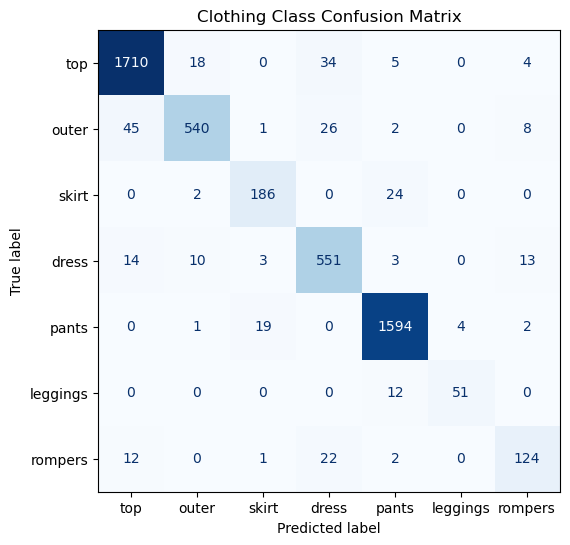

In [17]:
label_names = ['top', 'outer', 'skirt', 'dress', 'pants', 'leggings', 'rompers']

def evaluate_clothing_model(model, data_loader, device, normalizer, num_classes=7, label_names=None):
    model.eval()
    total_mse = 0.0
    total_samples = 0
    all_labels = []
    all_preds = []

    # Testing loop
    with torch.no_grad():
        for images, masks, labels in data_loader:
            # Only consider valid labels
            valid_mask = labels != -1
            if valid_mask.sum() == 0:
                continue

            # Select only valid samples
            images = images[valid_mask].to(device)
            masks = masks[valid_mask].to(device)
            labels = labels[valid_mask].to(device)

            # Expand mask to match image channels (Batch, 1, H, W) -> (Batch, 3, H, W)
            masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
            # Black out background
            masked_images = images * masks
            # Normalize
            model_inputs = normalizer(masked_images)

            # Get predictions
            outputs = model(model_inputs)
            preds = torch.argmax(outputs, dim=1)
            # Compute MSE
            total_mse += F.mse_loss(preds.float(), labels.float(), reduction='sum').item()
            total_samples += labels.size(0)
            
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    if total_samples == 0:
        print('No valid samples available for evaluation.')
        return

    # Compute Metrics
    mse = total_mse / total_samples
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    class_indices = list(range(num_classes))
    conf_mat = metrics.confusion_matrix(all_labels, all_preds, labels=class_indices)
    display_labels = label_names if label_names is not None else [str(idx) for idx in class_indices]

    print(f"MSE: {mse:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=display_labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title('Clothing Class Confusion Matrix')
    plt.show()

# Run on the current test data loader
evaluate_clothing_model(model, test_loader, device, normalizer, num_classes=7, label_names=label_names)


# **Image Classification by Color, Fabric, and Shape**

# Load Data

File Paths

In [31]:
PATTERN_ANN_PATH = "../data/labels/texture/pattern_ann.txt"
FABRIC_ANN_PATH = "../data/labels/texture/fabric_ann.txt"
SHAPE_ANN_PATH = "../data/labels/shape/shape_anno_all.txt"
IGNORE_ATTR_INDEX = -1  # use as ignore_index for padded targets

Load Pattern, Fabric, and Shape Annotations

In [32]:
def load_region_annotations(path):
    data = {}
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 4:
                continue
            img = parts[0]
            upper, lower, outer = map(int, parts[1:4])
            data[img] = {"upper": upper, "lower": lower, "outer": outer}
    return data

def load_shape_annotations(path):
    data = {}
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 13:
                continue
            data[parts[0]] = list(map(int, parts[1:13]))
    return data

pattern_ann = load_region_annotations(PATTERN_ANN_PATH)
fabric_ann = load_region_annotations(FABRIC_ANN_PATH)
shape_ann = load_shape_annotations(SHAPE_ANN_PATH)

In [46]:
class FashionStyleMarkersDataset(Dataset):
    def __init__(self, img_dir, segm_dir, transform=None):
        self.img_dir = img_dir
        self.segm_dir = segm_dir
        self.transform = transform

        self.target_map = {
            1: 0,  # top -> class 0
            2: 1,  # outer -> class 1
            3: 2,  # skirt -> class 2
            4: 3,  # dress -> class 3
            5: 4,  # pants -> class 4
            6: 5,  # leggings -> class 5
            21: 6  # rompers -> class 6
        }
        self.region_map = {
            0: "upper",  # top
            1: "outer",  # outer
            2: "lower",  # skirt
            3: "upper",  # dress
            4: "lower",  # pants
            5: "lower",  # leggings
            6: "upper"   # rompers
        }

        self.samples = []
        all_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
        print(f"Building style markers dataset from {len(all_files)} images...")
        
        # Use tqdm to show progress bcs this might take a while
        for img_name in tqdm(all_files):
            segm_path = os.path.join(segm_dir, f"{os.path.splitext(img_name)[0]}_segm.png")
            if not os.path.exists(segm_path):
                continue
            if img_name not in pattern_ann or img_name not in fabric_ann or img_name not in shape_ann:
                continue

            # Load segmentation mask
            segm_np = np.array(Image.open(segm_path))
            for original_id in np.unique(segm_np):
                if original_id not in self.target_map:
                    continue

                type_label = self.target_map[original_id]
                region = self.region_map[type_label]

                mask_pixels = int((segm_np == original_id).sum())
                if mask_pixels == 0:
                    continue  # nothing to learn from this mask

                pattern_label = pattern_ann[img_name][region]
                fabric_label = fabric_ann[img_name][region]
                if pattern_label < 0 or fabric_label < 0:
                    continue  # invalid annotations

                def __sanitize_shape__(value, na_codes):
                    return value if value not in na_codes else IGNORE_ATTR_INDEX

                # Get shape targets
                shape_values = shape_ann[img_name]
                shape_targets = [IGNORE_ATTR_INDEX] * 4
                if region == "upper":
                    shape_targets[0] = __sanitize_shape__(shape_values[9], {6})   # neckline NA=6
                    shape_targets[1] = __sanitize_shape__(shape_values[11], {2}) # upper_cover NA=2
                elif region == "lower":
                    shape_targets[2] = __sanitize_shape__(shape_values[1], {4})  # lower_length NA=4
                elif region == "outer":
                    shape_targets[3] = __sanitize_shape__(shape_values[10], {2}) # outer_cardigan NA=2

                if all(t == IGNORE_ATTR_INDEX for t in shape_targets):
                    continue  # this segment has no usable shape labels

                self.samples.append({
                    "img": img_name,
                    "seg_id": original_id,
                    "type_label": type_label,
                    "pattern_label": pattern_label,
                    "fabric_label": fabric_label,
                    "shape_targets": shape_targets,
                })

        if not self.samples:
            raise RuntimeError("No samples available with complete annotations.")
        print(f"Multi-head dataset ready with {len(self.samples)} masked clothing items.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Get image and segm file paths
        sample = self.samples[idx]
        img_path = os.path.join(self.img_dir, sample["img"])
        segm_path = os.path.join(self.segm_dir, f"{os.path.splitext(sample['img'])[0]}_segm.png")

        # Load Image and Mask it based on segm
        image = Image.open(img_path).convert("RGB")
        segm = np.array(Image.open(segm_path))
        mask_binary = (segm == sample["seg_id"]).astype(np.uint8)
        
        # Resize Mask to match ResNet Model Input (224x224)
        mask_img = Image.fromarray(mask_binary).resize((224, 224), resample=Image.NEAREST)
        mask_tensor = torch.tensor(np.array(mask_img), dtype=torch.float32)
        
        # if mask_tensor.sum() == 0:
        #     raise RuntimeError(f"Empty mask detected for {sample['img']} segment {sample['seg_id']}.")


        if self.transform:
            image = self.transform(image)

        return (
            image,
            mask_tensor,
            torch.tensor(sample["type_label"], dtype=torch.long),
            torch.tensor(sample["pattern_label"], dtype=torch.long),
            torch.tensor(sample["fabric_label"], dtype=torch.long),
            torch.tensor(sample["shape_targets"], dtype=torch.long),
        )



In [47]:
# Initalize with Train-Test Split
multi_head_dataset = FashionStyleMarkersDataset(IMAGE_DIR, SEGM_DIR, transform=transform)

train_len = int(0.8 * len(multi_head_dataset))
test_len = len(multi_head_dataset) - train_len
multi_train_set, multi_test_set = random_split(
    multi_head_dataset,
    [train_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

multi_train_loader = DataLoader(multi_train_set, batch_size=32, shuffle=True)
multi_test_loader = DataLoader(multi_test_set, batch_size=32, shuffle=False)

print("Style markers dataset ready.")
print(f"Total Samples: {len(multi_head_dataset)} | Train: {train_len} | Test: {test_len}")

Building style markers dataset from 44096 images...


100%|██████████| 44096/44096 [01:35<00:00, 462.23it/s]

Multi-head dataset ready with 24108 masked clothing items.
Style markers dataset ready.
Total Samples: 24108 | Train: 19286 | Test: 4822


# Model 2

In [48]:
class MultiHeadResNet(nn.Module):
    def __init__(
        self,
        num_types,
        num_pattern_classes,
        num_fabric_classes,
        type_embed_dim=32,
    ):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # we only need pooled features

        self.type_embed = nn.Embedding(num_types, type_embed_dim)
        combined_dim = feat_dim + type_embed_dim

        self.pattern_head = nn.Linear(combined_dim, num_pattern_classes)
        self.fabric_head = nn.Linear(combined_dim, num_fabric_classes)

        self.shape_heads = nn.ModuleDict({
            "neckline": nn.Linear(combined_dim, 7),   # shape_9
            "upper_cover": nn.Linear(combined_dim, 3),# shape_11
            "lower_length": nn.Linear(combined_dim, 5),# shape_1
            "outer_cardigan": nn.Linear(combined_dim, 3),# shape_10
        })

    def forward(self, images, type_labels):
        feats = self.backbone(images)
        feats = feats.view(feats.size(0), -1)

        type_feats = self.type_embed(type_labels)
        combined = torch.cat([feats, type_feats], dim=1)

        outputs = {
            "pattern": self.pattern_head(combined),
            "fabric": self.fabric_head(combined),
            "neckline": self.shape_heads["neckline"](combined),
            "upper_cover": self.shape_heads["upper_cover"](combined),
            "lower_length": self.shape_heads["lower_length"](combined),
            "outer_cardigan": self.shape_heads["outer_cardigan"](combined),
        }
        return outputs

In [49]:
num_types = 7
num_pattern_classes = max(s["pattern_label"] for s in multi_head_dataset.samples) + 1
num_fabric_classes = max(s["fabric_label"] for s in multi_head_dataset.samples) + 1

multi_head_model = MultiHeadResNet(
    num_types=num_types,
    num_pattern_classes=num_pattern_classes,
    num_fabric_classes=num_fabric_classes,
).to(device)

# Train

Hyperparameters

In [50]:
multi_head_lr = 1e-4
multi_head_epochs = 8
attr_weights = {
    "pattern": 1.0,
    "fabric": 1.0,
    "neckline": 0.25,
    "upper_cover": 0.25,
    "lower_length": 0.25,
    "outer_cardigan": 0.25,
}

multi_head_optimizer = optim.Adam(multi_head_model.parameters(), lr=multi_head_lr)
pattern_criterion = nn.CrossEntropyLoss()
fabric_criterion = nn.CrossEntropyLoss()
shape_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_ATTR_INDEX)

Training Loop

In [51]:

for epoch in range(multi_head_epochs):
    multi_head_model.train()
    running_loss = 0.0

    for step, (
        images,
        masks,
        type_labels,
        pattern_labels,
        fabric_labels,
        shape_targets,
    ) in enumerate(multi_train_loader):
        
        images = images.to(device)
        masks = masks.to(device)
        type_labels = type_labels.to(device)
        pattern_labels = pattern_labels.to(device)
        fabric_labels = fabric_labels.to(device)
        shape_targets = shape_targets.to(device)
        
        valid_mask = (pattern_labels >= 0) & (fabric_labels >= 0)
        if valid_mask.sum() == 0:
            continue  # skip batches that lost every sample after filtering

        images = images[valid_mask]
        masks = masks[valid_mask]
        type_labels = type_labels[valid_mask]
        pattern_labels = pattern_labels[valid_mask]
        fabric_labels = fabric_labels[valid_mask]
        shape_targets = shape_targets[valid_mask]

        # Expand mask to match image channels (Batch, 1, H, W) -> (Batch, 3, H, W)
        masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
        # Black out background
        masked_images = images * masks
        # Normalize
        model_inputs = normalizer(masked_images)

        outputs = multi_head_model(model_inputs, type_labels)

        # Calculate Losses for regions
        loss_pattern = pattern_criterion(outputs["pattern"], pattern_labels)
        loss_fabric = fabric_criterion(outputs["fabric"], fabric_labels)

        def masked_shape_loss(head_key, column_idx):
            valid = shape_targets[:, column_idx] != IGNORE_ATTR_INDEX
            if valid.any():
                return shape_criterion(
                    outputs[head_key][valid],
                    shape_targets[:, column_idx][valid]
                )
            return torch.zeros(1, device=device, dtype=torch.float32)
        
        # Calculate shape losses
        loss_neckline = masked_shape_loss("neckline", 0)
        loss_upper_cover = masked_shape_loss("upper_cover", 1)
        loss_lower_length = masked_shape_loss("lower_length", 2)
        loss_outer_cardigan = masked_shape_loss("outer_cardigan", 3)

        shape_loss = (
            attr_weights["neckline"] * loss_neckline
            + attr_weights["upper_cover"] * loss_upper_cover
            + attr_weights["lower_length"] * loss_lower_length
            + attr_weights["outer_cardigan"] * loss_outer_cardigan
        )

        total_loss = (
            attr_weights["pattern"] * loss_pattern
            + attr_weights["fabric"] * loss_fabric
            + shape_loss
        )
        
        # Train Step
        multi_head_optimizer.zero_grad()
        total_loss.backward()
        multi_head_optimizer.step()
        running_loss += total_loss.item()

        if step % 100 == 0:
            print(f"Epoch [{epoch+1}/{multi_head_epochs}], Step [{step}], Loss: {total_loss.item():.4f}")

    avg_loss = running_loss / len(multi_train_loader)
    print(f"Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}")


Epoch [1/8], Step [0], Loss: 5.6068
Epoch [1/8], Step [100], Loss: 2.6169
Epoch [1/8], Step [200], Loss: 1.7848
Epoch [1/8], Step [300], Loss: 1.5396
Epoch [1/8], Step [400], Loss: 2.0114
Epoch [1/8], Step [500], Loss: 1.4006
Epoch [1/8], Step [600], Loss: 1.4046
Epoch 1 complete. Average Loss: 1.9620
Epoch [2/8], Step [0], Loss: 1.1485
Epoch [2/8], Step [100], Loss: 1.1703
Epoch [2/8], Step [200], Loss: 1.4066
Epoch [2/8], Step [300], Loss: 1.3320
Epoch [2/8], Step [400], Loss: 0.9585
Epoch [2/8], Step [500], Loss: 1.5206
Epoch [2/8], Step [600], Loss: 1.1440
Epoch 2 complete. Average Loss: 1.3381
Epoch [3/8], Step [0], Loss: 1.1925
Epoch [3/8], Step [100], Loss: 1.1321
Epoch [3/8], Step [200], Loss: 1.1087
Epoch [3/8], Step [300], Loss: 1.3298
Epoch [3/8], Step [400], Loss: 0.9365
Epoch [3/8], Step [500], Loss: 1.0745
Epoch [3/8], Step [600], Loss: 0.9281
Epoch 3 complete. Average Loss: 1.0672
Epoch [4/8], Step [0], Loss: 0.6525
Epoch [4/8], Step [100], Loss: 0.8793
Epoch [4/8], Step

# Test

In [60]:
def evaluate_multi_head(model, data_loader, device):
    model.eval()
    metrics = {
        "Pattern": {"correct": 0, "total": 0, "sqerr": 0.0},
        "Fabric": {"correct": 0, "total": 0, "sqerr": 0.0},
    }
    shape_metrics = {
        "neckline": {"correct": 0, "total": 0, "sqerr": 0.0},
        "upper_cover": {"correct": 0, "total": 0, "sqerr": 0.0},
        "lower_length": {"correct": 0, "total": 0, "sqerr": 0.0},
        "outer_cardigan": {"correct": 0, "total": 0, "sqerr": 0.0},
        "overall": {"correct": 0, "total": 0, "sqerr": 0.0},
    }

    def update_metric(preds, targets, tracker):
        if targets.numel() == 0:
            return
        tracker["correct"] += (preds == targets).sum().item()
        tracker["total"] += targets.numel()
        tracker["sqerr"] += torch.sum((preds.float() - targets.float()) ** 2).item()

    with torch.no_grad():
        for batch in data_loader:
            (
                images,
                masks,
                type_labels,
                pattern_labels,
                fabric_labels,
                shape_targets,
            ) = batch

            valid_mask = (pattern_labels >= 0) & (fabric_labels >= 0)
            if valid_mask.sum() == 0:
                continue

            images = images[valid_mask].to(device)
            masks = masks[valid_mask].to(device)
            type_labels = type_labels[valid_mask].to(device)
            pattern_labels = pattern_labels[valid_mask].to(device)
            fabric_labels = fabric_labels[valid_mask].to(device)
            shape_targets = shape_targets[valid_mask].to(device)

            masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
            masked_images = images * masks
            model_inputs = normalizer(masked_images)
            outputs = model(model_inputs, type_labels)

            pattern_preds = outputs["pattern"].argmax(dim=1)
            fabric_preds = outputs["fabric"].argmax(dim=1)
            update_metric(pattern_preds, pattern_labels, metrics["Pattern"])
            update_metric(fabric_preds, fabric_labels, metrics["Fabric"])

            shape_heads = [
                ("neckline", 0),
                ("upper_cover", 1),
                ("lower_length", 2),
                ("outer_cardigan", 3),
            ]
            for head_key, col in shape_heads:
                valid = shape_targets[:, col] != IGNORE_ATTR_INDEX
                if valid.any():
                    preds = outputs[head_key][valid].argmax(dim=1)
                    targets = shape_targets[:, col][valid]
                    update_metric(preds, targets, shape_metrics[head_key])
                    update_metric(preds, targets, shape_metrics["overall"])

    for key, tracker in metrics.items():
        if tracker["total"] == 0:
            print(f"{key}: no valid samples.")
            continue
        acc = tracker["correct"] / tracker["total"]
        mse = tracker["sqerr"] / tracker["total"]
        print(f"{key} | Accuracy: {acc * 100:.2f}% | MSE: {mse:.4f}")

    print()
    for key, tracker in shape_metrics.items():
        if tracker["total"] == 0:
            print(f"{key}: no valid shape samples.")
            continue
        acc = tracker["correct"] / tracker["total"]
        mse = tracker["sqerr"] / tracker["total"]
        if key == "overall":
            print(f"Shape | Accuracy: {acc * 100:.2f}% | MSE: {mse:.4f}")
        else:
            print(f"\tshape: {key} | Accuracy: {acc * 100:.2f}% | MSE: {mse:.4f}")

evaluate_multi_head(multi_head_model, multi_test_loader, device)


Pattern | Accuracy: 81.54% | MSE: 1.1296
Fabric | Accuracy: 81.31% | MSE: 1.9243

	shape: neckline | Accuracy: 81.98% | MSE: 1.1618
	shape: upper_cover | Accuracy: 92.12% | MSE: 0.0788
	shape: lower_length | Accuracy: 95.39% | MSE: 0.1350
	shape: outer_cardigan | Accuracy: 91.64% | MSE: 0.0836
Shape | Accuracy: 89.73% | MSE: 0.4377


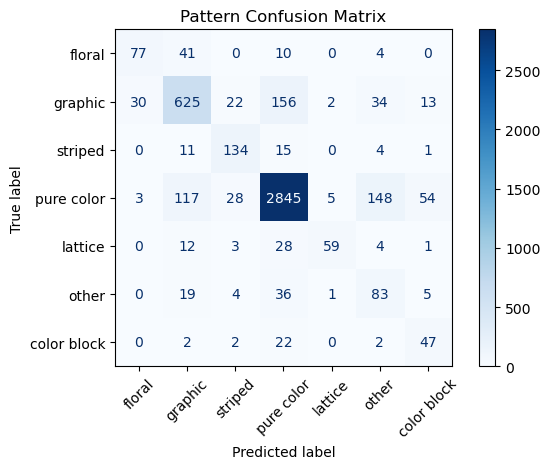

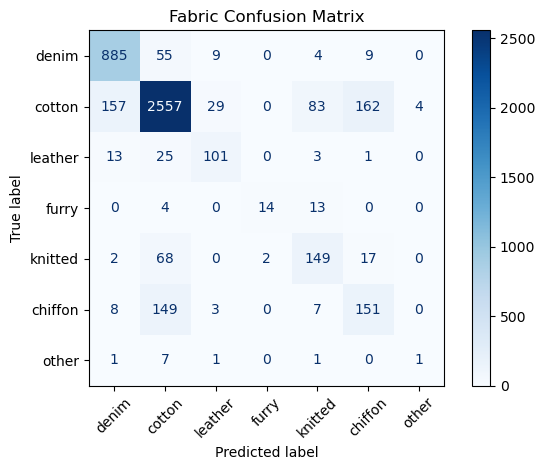

In [62]:
pattern_label_names = [
    "floral", "graphic", "striped", "pure color",
    "lattice", "other", "color block", "NA"
]
fabric_label_names = [
    "denim", "cotton", "leather", "furry",
    "knitted", "chiffon", "other", "NA"
]

def plot_attr_confusions(model, data_loader, device):
    model.eval()
    pattern_truths, pattern_preds = [], []
    fabric_truths, fabric_preds = [], []

    with torch.no_grad():
        for (
            images,
            masks,
            type_labels,
            pattern_labels,
            fabric_labels,
            shape_targets,
        ) in data_loader:

            valid = (pattern_labels >= 0) & (fabric_labels >= 0)
            if valid.sum() == 0:
                continue

            images = images[valid].to(device)
            masks = masks[valid].to(device)
            type_labels = type_labels[valid].to(device)
            pattern_labels = pattern_labels[valid]
            fabric_labels = fabric_labels[valid]

            masks = masks.unsqueeze(1).repeat(1, 3, 1, 1)
            masked_images = images * masks
            model_inputs = normalizer(masked_images)
            outputs = model(model_inputs, type_labels)

            pattern_logits = outputs["pattern"].cpu()
            fabric_logits = outputs["fabric"].cpu()

            pattern_truths.extend(pattern_labels.tolist())
            pattern_preds.extend(pattern_logits.argmax(dim=1).tolist())
            fabric_truths.extend(fabric_labels.tolist())
            fabric_preds.extend(fabric_logits.argmax(dim=1).tolist())

    def build_confusion(truths, preds, labels, display_labels, title):
        valid = [i for i, y in enumerate(truths) if y != 7]
        truths = [truths[i] for i in valid]
        preds = [preds[i] for i in valid]
        cm = metrics.confusion_matrix(truths, preds, labels=list(range(len(display_labels) - 1)))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels[:-1])
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    build_confusion(pattern_truths, pattern_preds, pattern_label_names, pattern_label_names,
                    "Pattern Confusion Matrix")
    build_confusion(fabric_truths, fabric_preds, fabric_label_names, fabric_label_names,
                    "Fabric Confusion Matrix")

plot_attr_confusions(multi_head_model, multi_test_loader, device)
